In [5]:
using Revise, HarmonicBalance, DifferentialEquations
import HarmonicBalance.TimeEvolution: ParameterSweep, ODEProblem

# Harmonic equations for the parametric oscillator

In [6]:
@variables Ω, γ, λ, F, x, θ, η, α, ω, ψ, T, t, x(t)

natural_equation =  d(d(x,t),t) + γ*d(x,t) + Ω^2*(1-λ*cos(2*ω*t+ψ))*x + α*x^3 + η*d(x,t)*x^2
force =  F*cos(ω*t+θ)
dEOM = HarmonicBalance.DifferentialEquation(natural_equation + force, x)
HarmonicBalance.add_harmonic!(dEOM, x, ω); # single-frequency ansatz

# construct the harmonic equations
harmonic_eqs = HarmonicBalance.get_harmonic_equations(dEOM, slow_time=T, fast_time=t)

A set of 2 harmonic equations
Variables: u1(T), v1(T)
Parameters: α, ω, F, θ, γ, η, Ω, λ, ψ

Harmonic ansatz: 
x(t) = u1(T)*cos(ωt) + v1(T)*sin(ωt)

Harmonic equations:

F*cos(θ) + γ*Differential(T)(u1(T)) + (Ω^2)*u1(T) + (3//4)*α*(u1(T)^3) + γ*ω*v1(T) + (2//1)*ω*Differential(T)(v1(T)) + (3//4)*α*(v1(T)^2)*u1(T) + (1//4)*η*ω*(v1(T)^3) + (3//4)*η*(u1(T)^2)*Differential(T)(u1(T)) + (1//4)*η*(v1(T)^2)*Differential(T)(u1(T)) + (1//4)*η*ω*(u1(T)^2)*v1(T) + (1//2)*η*u1(T)*v1(T)*Differential(T)(v1(T)) + (1//2)*λ*(Ω^2)*v1(T)*sin(ψ) - (ω^2)*u1(T) - (1//2)*λ*(Ω^2)*u1(T)*cos(ψ) ~ 0

(Ω^2)*v1(T) + γ*Differential(T)(v1(T)) + (3//4)*α*(v1(T)^3) + (1//4)*η*(u1(T)^2)*Differential(T)(v1(T)) + (3//4)*α*(u1(T)^2)*v1(T) + (3//4)*η*(v1(T)^2)*Differential(T)(v1(T)) + (1//2)*λ*(Ω^2)*u1(T)*sin(ψ) + (1//2)*λ*(Ω^2)*v1(T)*cos(ψ) + (1//2)*η*u1(T)*v1(T)*Differential(T)(u1(T)) - F*sin(θ) - (ω^2)*v1(T) - (2//1)*ω*Differential(T)(u1(T)) - (1//4)*η*ω*(u1(T)^3) - γ*ω*u1(T) - (1//4)*η*ω*(v1(T)^2)*u1(T) ~ 0


# first let's see the steady state diagram

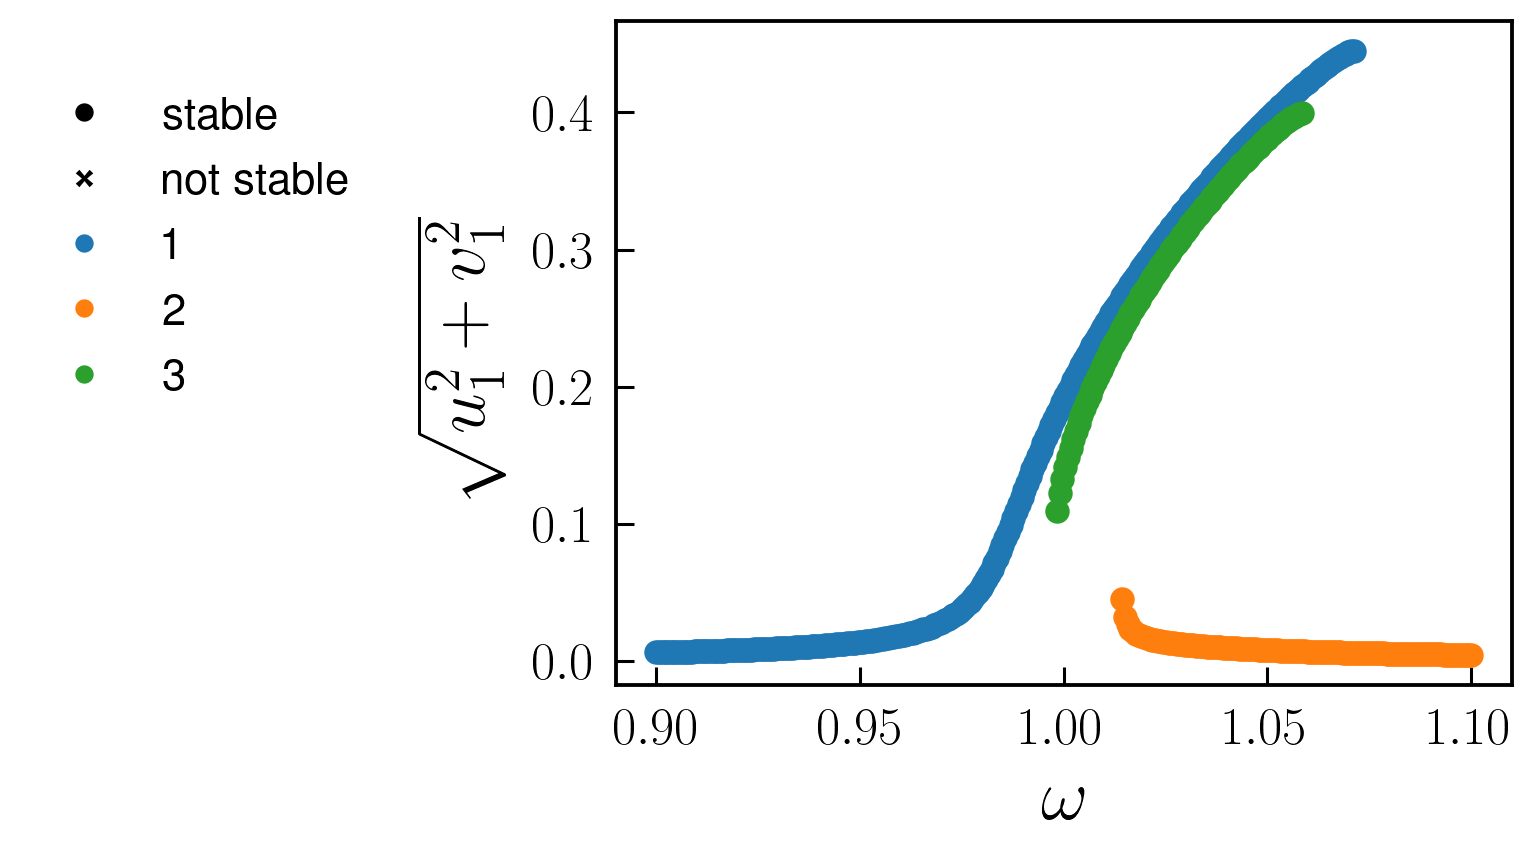

In [47]:
fixed = (Ω => 1.0,γ => 1E-2, λ => 5E-2, F => 1E-3,  α => 1.,  η=>0.3, θ => 0, ψ => 0)
swept = ω => LinRange(0.9, 1.1, 300)           # range of parameter values
solutions = get_steady_states(harmonic_eqs, swept, fixed)
HarmonicBalance.plot(solutions, x="ω", y="sqrt(u1^2 + v1^2)",plot_only=["physical", "stable"]);
#HarmonicBalance.savefig("parametron_response.png")

# single sweep

In [49]:
sweep = ParameterSweep(ω=>(0.9, 1.1), (0, 2E4)) # linearly interpolate between two values at two times
ode_problem = ODEProblem(harmonic_eqs, fixed, sweep=sweep, x0=[0.2;0.2], timespan=(0, 2E4))

ODEProblem with uType Vector{Float64} and tType Float64. In-place: true
timespan: (0.0, 20000.0)
u0: 2-element Vector{Float64}:
 0.2
 0.2

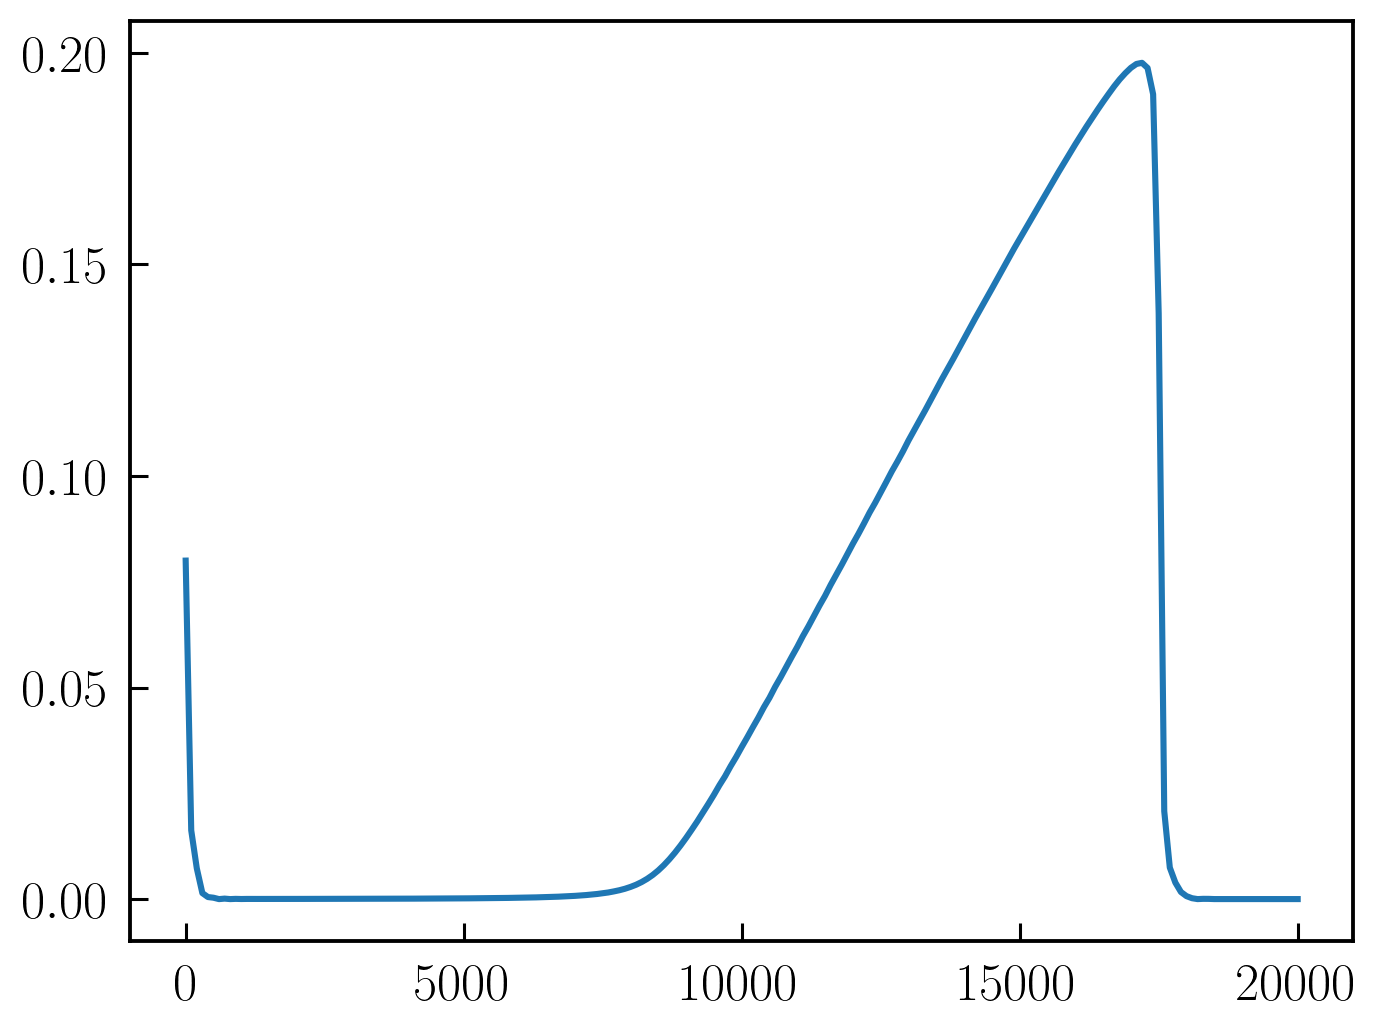

  9.125966 seconds (32.62 M allocations: 1.079 GiB, 4.37% gc time)


In [50]:
@time time_soln = solve(ode_problem,saveat=100);
HarmonicBalance.plot(time_soln, "u1^2 + v1^2", harmonic_eqs);

# simultaneous sweep of multiple parameters

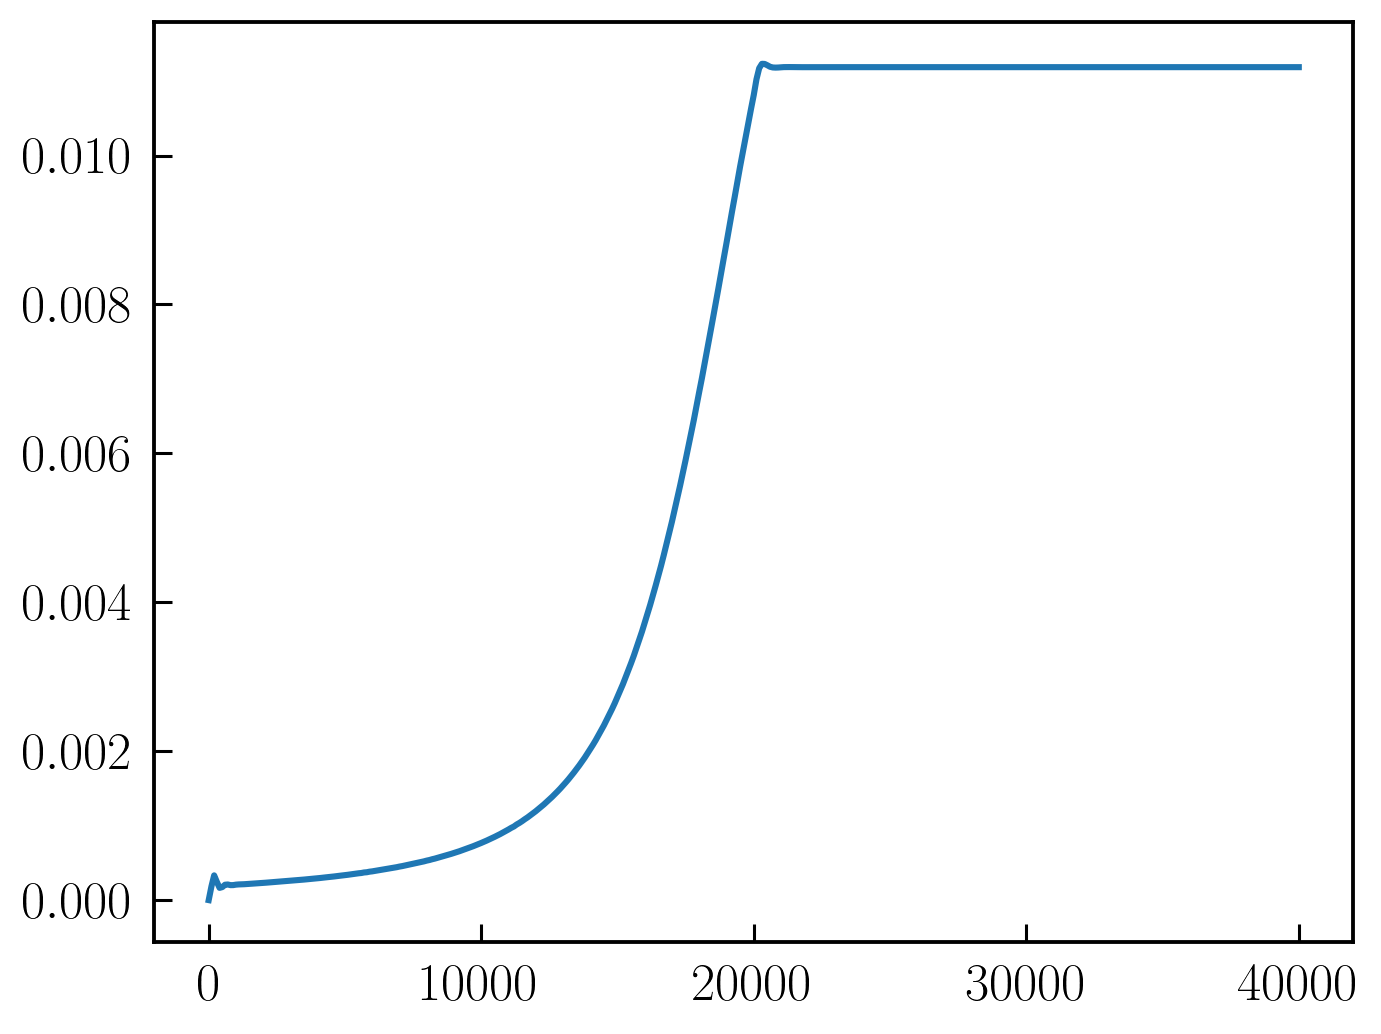

  3.928984 seconds (15.46 M allocations: 524.782 MiB, 3.24% gc time)


In [51]:
# interpolate both parameters
sw_params = [ω=>[0.95;1.0],λ => [5E-2;1E-2]]
sweep=ParameterSweep(sw_params, (0, 2E4))

ode_problem = ODEProblem(harmonic_eqs, fixed, sweep=sweep; x0=[0.0001;0.0001], timespan=(0,4E4))

@time time_soln = solve(ode_problem,saveat=100);
HarmonicBalance.plot(time_soln, "u1^2 + v1^2", harmonic_eqs);

# series of sweeps

In [52]:
# combine two sweeps
sweep1 = ParameterSweep(ω => [0.95, 1.0], (0, 2E4))
sweep2 = ParameterSweep(λ => [0.05, 0.01], (2E4, 4E4))
sweep = sweep1 + sweep2

fixed_parameters = (Ω => 1.0,γ => 1E-2, λ => 5E-2, F => 1E-3,  α => 1.,  η=>0.3, θ => 0, ψ => 0)

ode_problem = ODEProblem(harmonic_eqs, fixed, sweep=sweep; x0=[0.0001;0.0001], timespan=(0, 4E4));

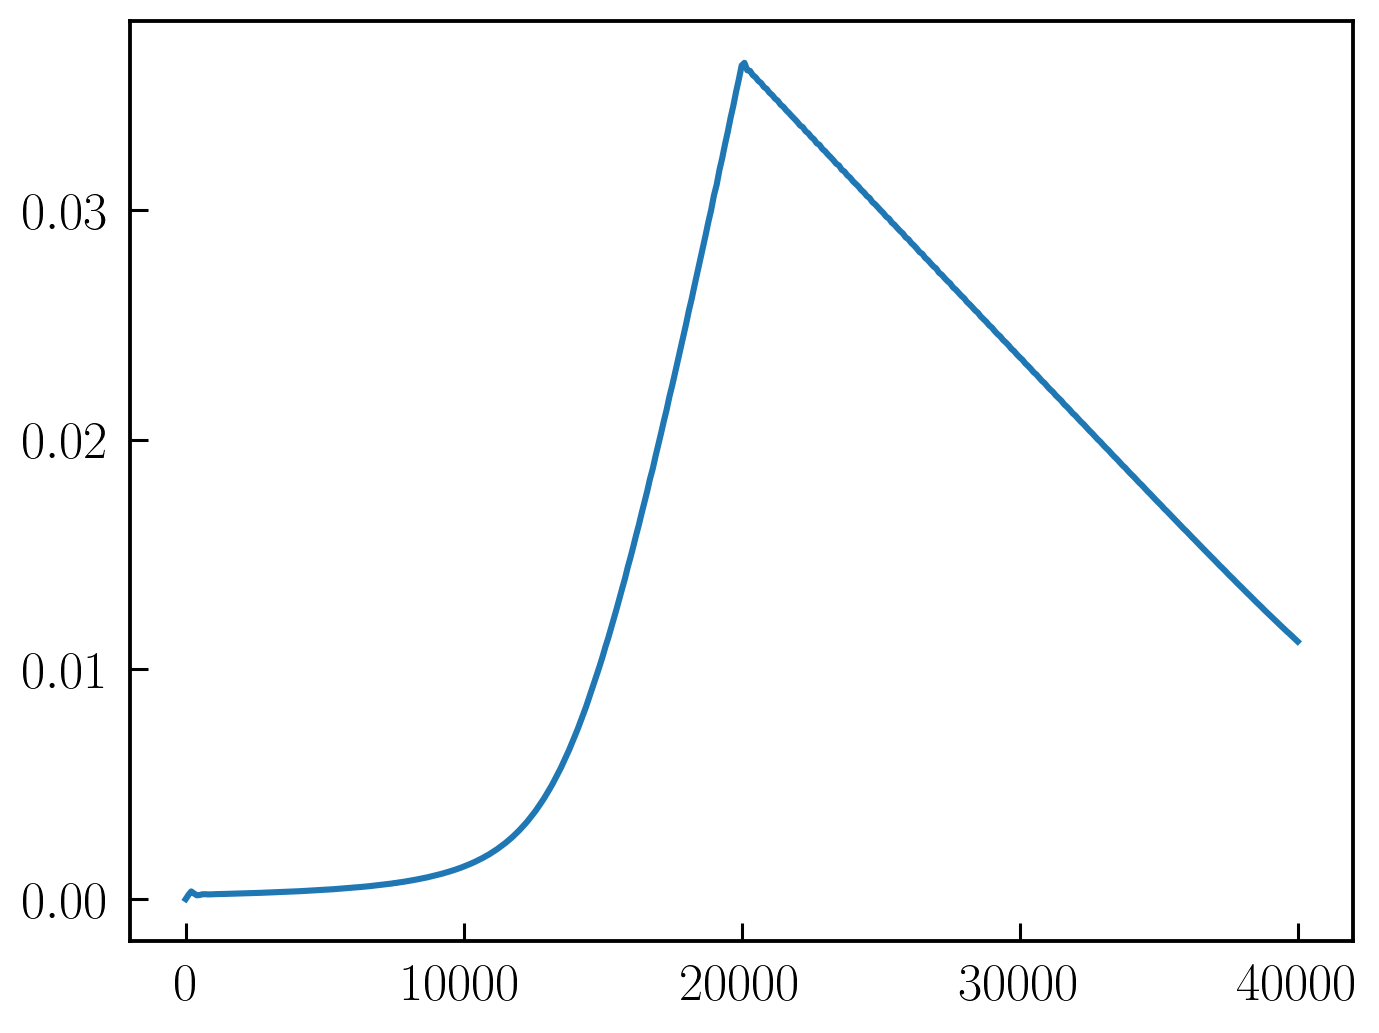

  5.607549 seconds (20.80 M allocations: 706.100 MiB, 3.88% gc time)


In [53]:
@time time_soln = solve(ode_problem,saveat=100);
HarmonicBalance.plot(time_soln, "u1^2 + v1^2", harmonic_eqs);

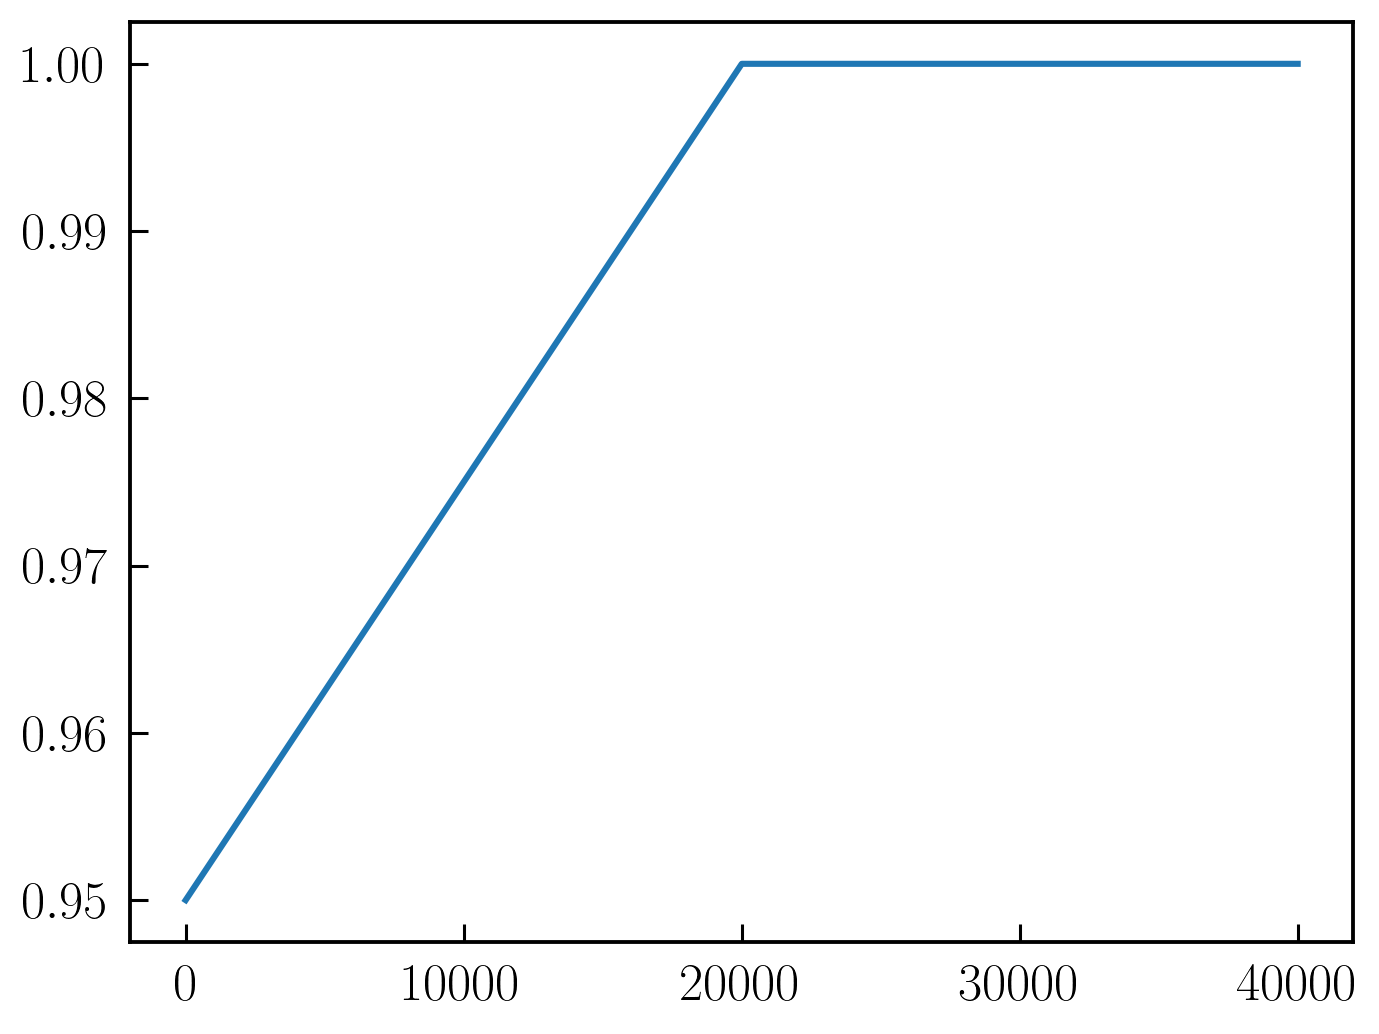

In [54]:
# check out our swept function
times = 0:4E4
HarmonicBalance.plot(times, sweep[ω].(times));

# Define custom sweep functions

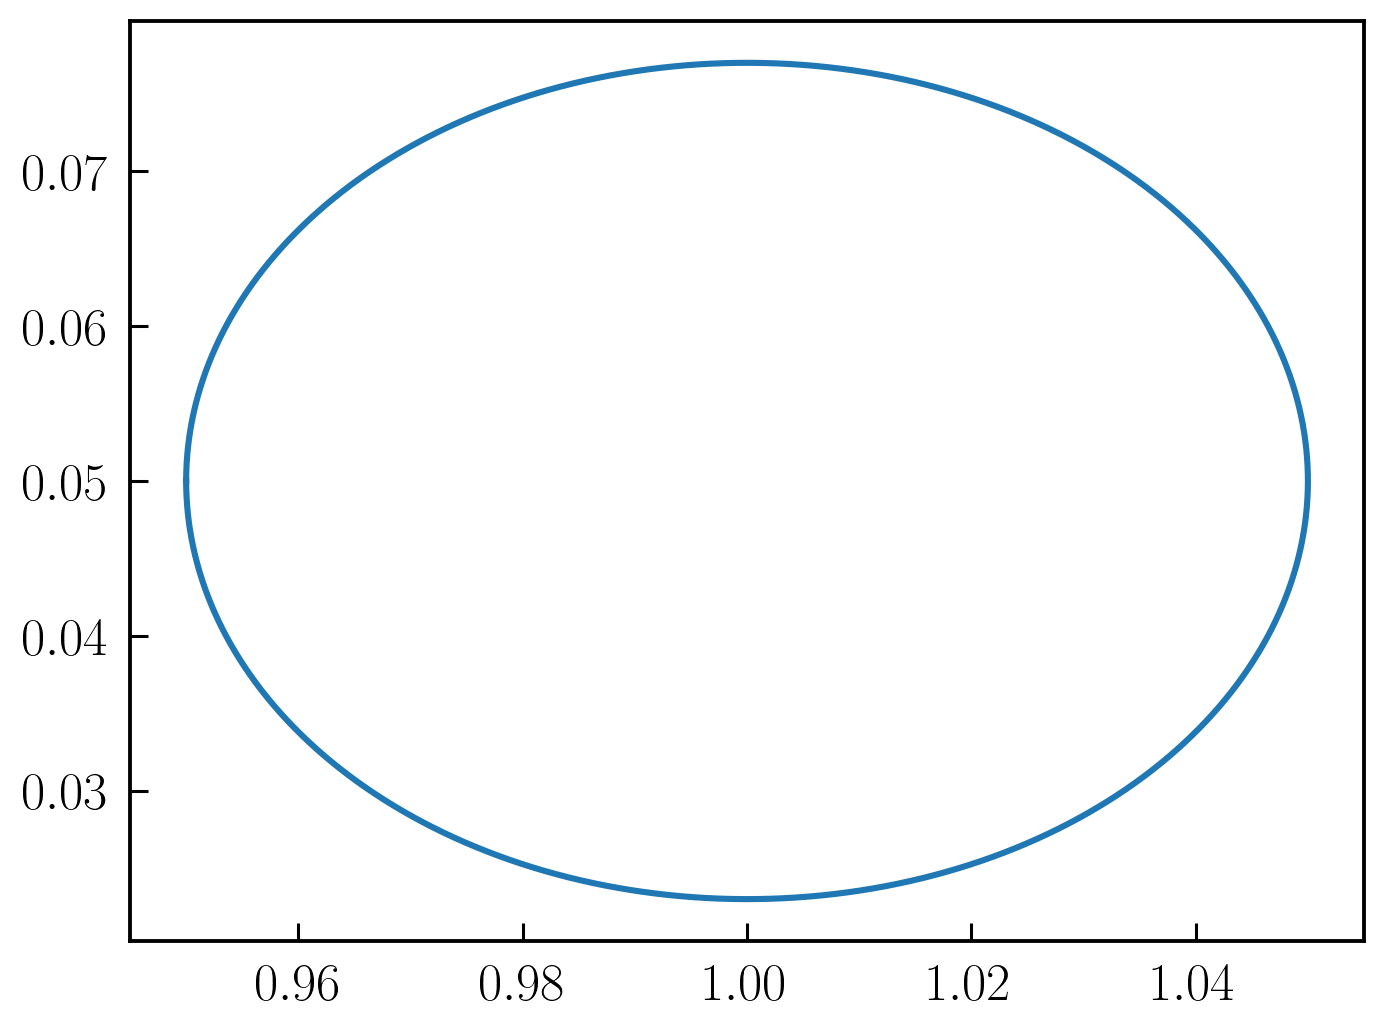

In [55]:
times = 0:2E4
ωfunc(t)=1-0.05*cos(2*pi*t/times[end])
λfunc(t)=0.05-0.027*sin(2*pi*t/times[end])
sweep_circle=ParameterSweep([ω => ωfunc,λ => λfunc])
# check the swept functions
HarmonicBalance.plot((sweep_circle[ω].(times)),(sweep_circle[λ].(times)));

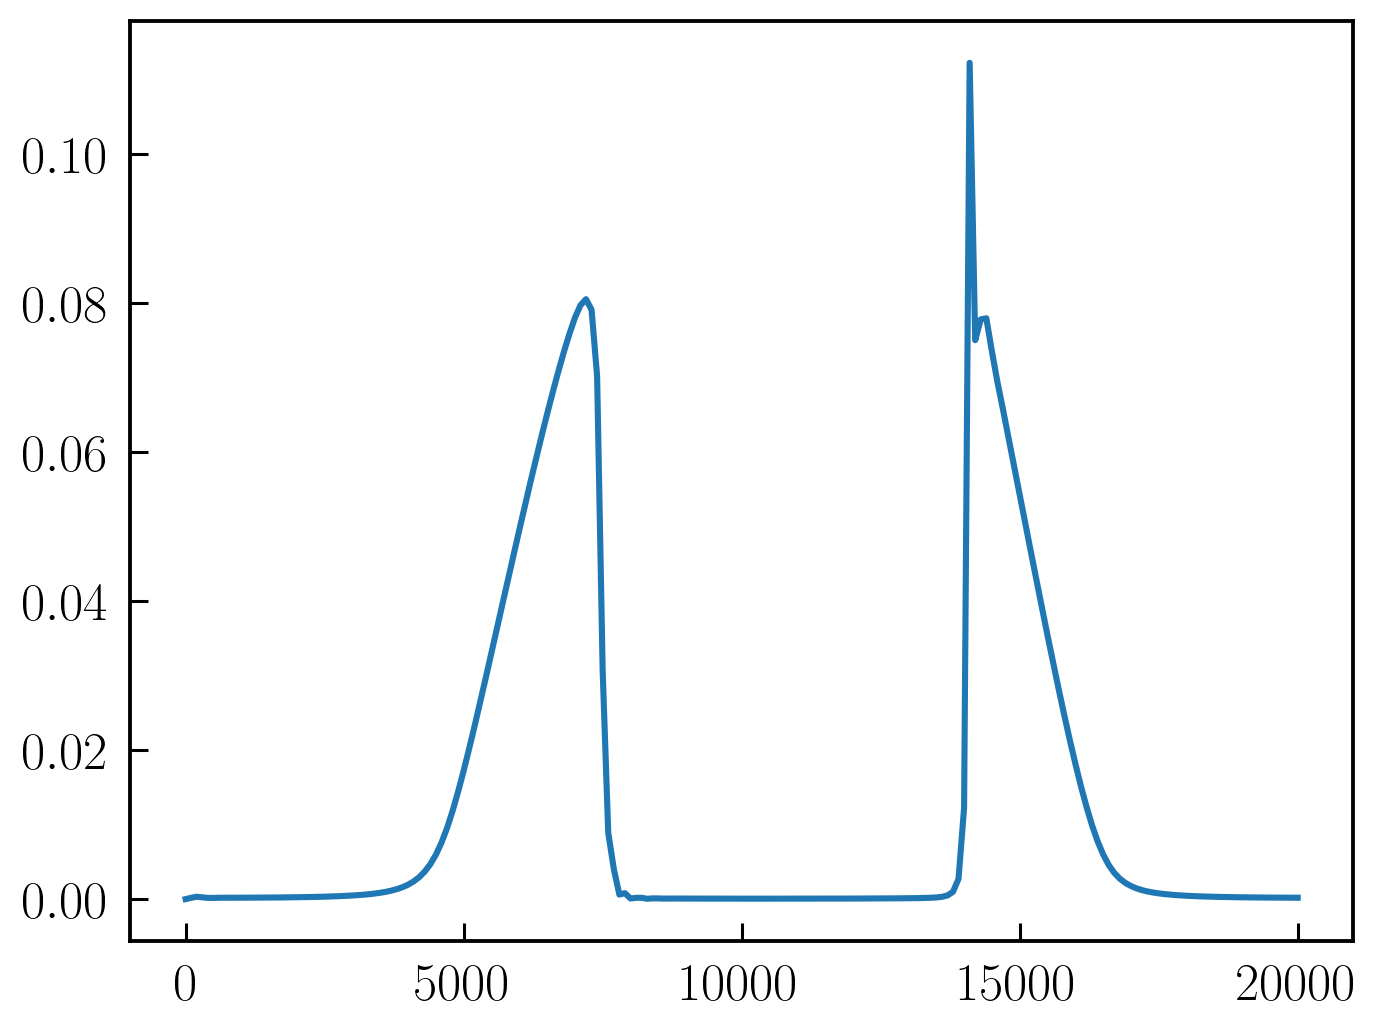

  6.980813 seconds (21.77 M allocations: 737.930 MiB, 3.46% gc time)


In [56]:
ode_problem = ODEProblem(harmonic_eqs, fixed,sweep=sweep_circle; x0=[0.0001;0.0001], timespan=(0, 2E4))
@time time_soln = solve(ode_problem,saveat=100);
HarmonicBalance.plot(time_soln, "u1^2 + v1^2", harmonic_eqs);

# Use steady-state solutions as initial conditions

In [57]:
range = ParameterRange(ω => LinRange(1.03,1.1,100))
steady_soln = get_steady_states(harmonic_eqs, range, fixed)

A steady state result for 100 parameter points

Solution branches:   5
   of which real:    5
   of which stable:  3

Classes: stable, physical, Hopf, binary_labels


In [58]:
# select a solution and evolve from it
s1 = get_single_solution(steady_soln, branch=1, index=1);
s2 = get_single_solution(steady_soln, branch=2, index=1);
s3 = get_single_solution(steady_soln, branch=3, index=1);

sweep = ParameterSweep(ω => (1.03, 1.1), (0, 1E4))
function t_solve(s)
    problem = ODEProblem(harmonic_eqs, s, timespan=(0,1E4), sweep=sweep)
    time_soln = solve(problem,saveat=10);
end

t_solve (generic function with 1 method)

In [59]:
# time-evolve all three solutions
time_soln_1 = t_solve(s1)
time_soln_2 = t_solve(s2)
time_soln_3 = t_solve(s3);

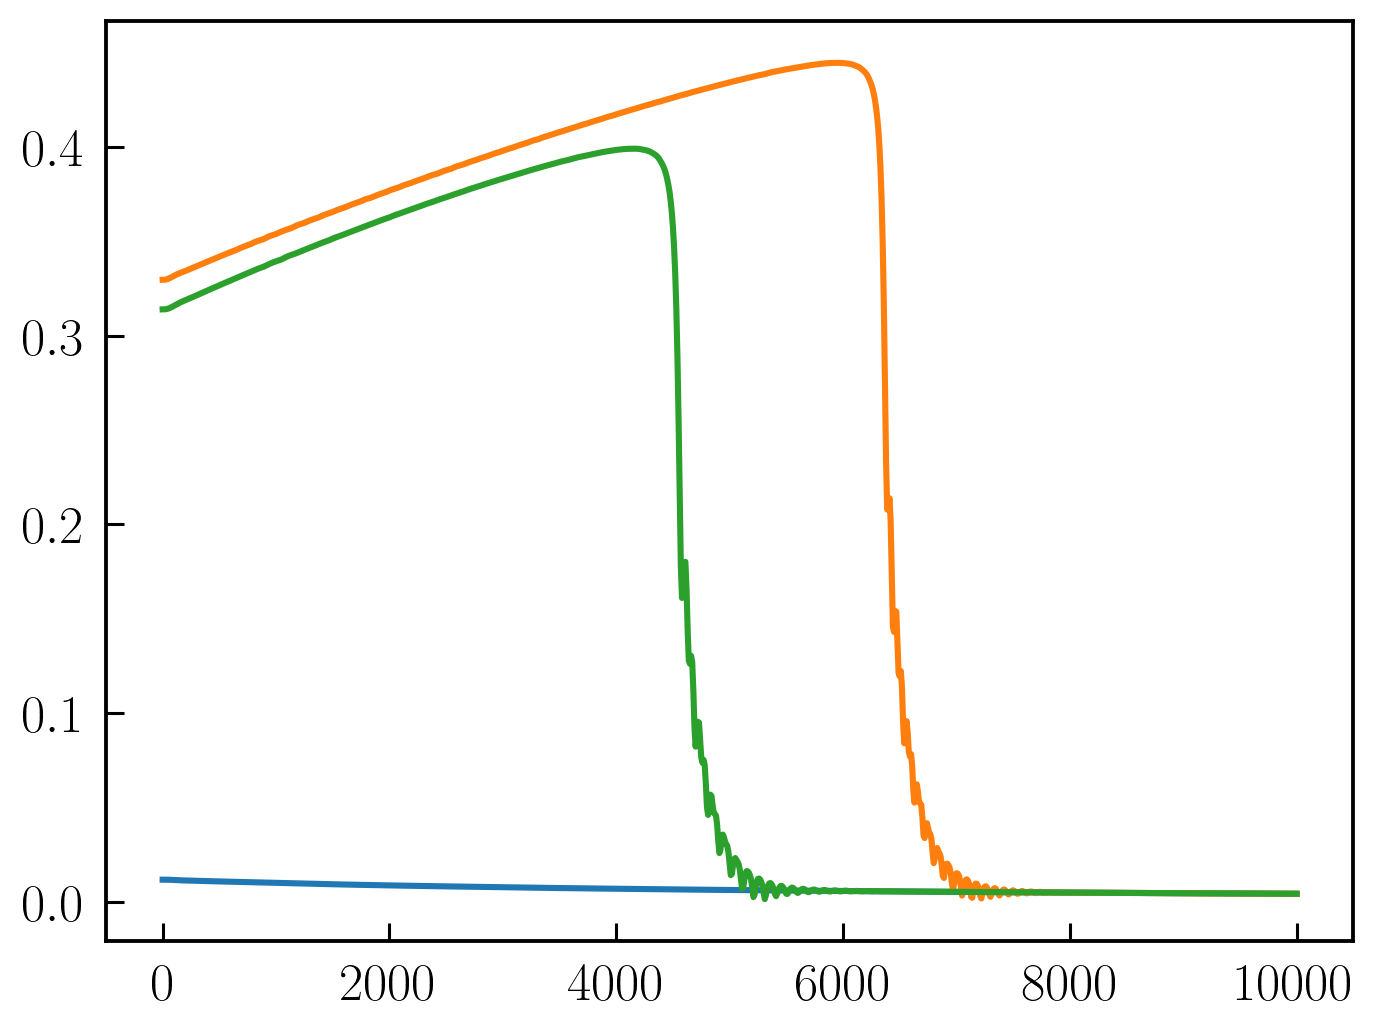

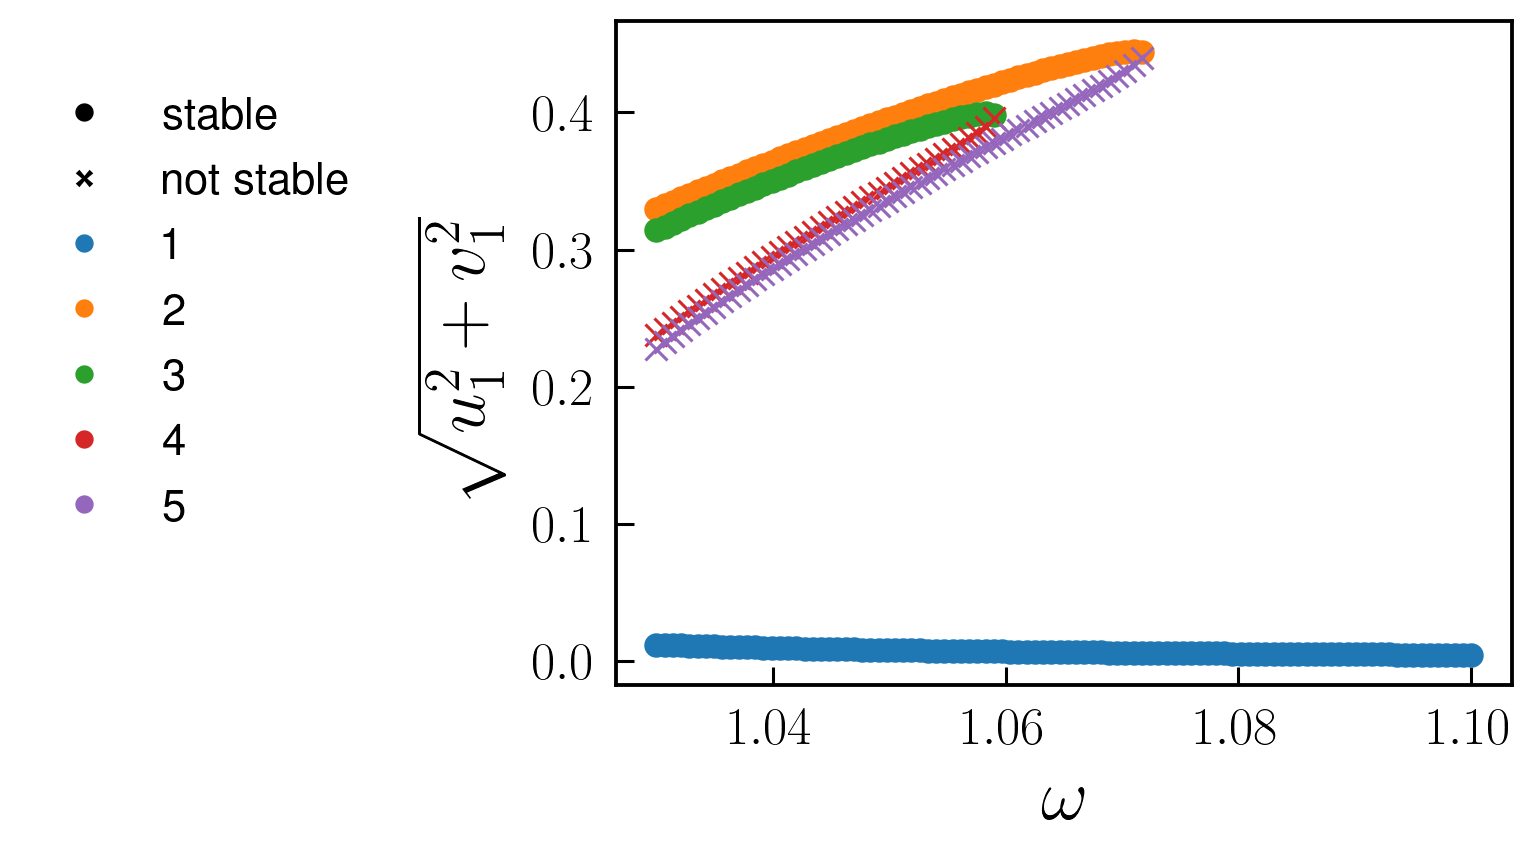

In [61]:
# contrast to steady-state solution
plot_td(s) = HarmonicBalance.plot(s.t, sqrt.(getindex.(s.u,1).^2 .+ getindex.(s.u,2).^2))
plot_td(time_soln_1)
plot_td(time_soln_2)
plot_td(time_soln_3)
HarmonicBalance.plot(steady_soln, x="ω", y="sqrt(u1^2 + v1^2)");